# Make stationary SPG non-stationary

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

In [2]:
#pathway = "rcp85"
pathway = "ssp245"

location = "christchurch"
#location = "tauranga"

spg_run = 1

## MAGICC: Date to T'<sub>SH Land</sub>

Leroy created a CSV file with MAGICC data.  We create a function that, given a date, returns the (interpolated) T'<sub>SH Land</sub>.

In [3]:
# Load MAGICC data
magicc_path = Path("../data/magic_tprime_sh_land.csv")
magicc_df = pd.read_csv(magicc_path, index_col="date", parse_dates=True)
magicc_df.head()

,rcp26,rcp45,rcp60,rcp85,ssp119,ssp126,ssp245,ssp370,ssp434,ssp460,ssp585
date,,,,,,,,,,,
1765-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1766-01-01,0.036236,0.036236,0.036236,0.036236,0.012942,0.012942,0.012942,0.012942,0.012942,0.012942,0.012942
1767-01-01,0.051246,0.051246,0.051246,0.051246,-0.020676,-0.020676,-0.020676,-0.020676,-0.020676,-0.020676,-0.020676
1768-01-01,0.063496,0.063496,0.063496,0.063496,-0.023505,-0.023505,-0.023505,-0.023505,-0.023505,-0.023505,-0.023505
1769-01-01,0.075762,0.075762,0.075762,0.075762,0.013411,0.013411,0.013411,0.013411,0.013411,0.013411,0.013411


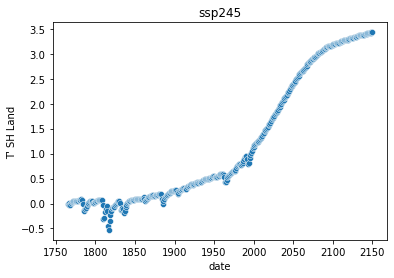

In [4]:
ax = sns.scatterplot(x=magicc_df.index, y=magicc_df[pathway])
ax.set_title(pathway)
ax.set_ylabel("T' SH Land")
None # don't return a value

In [5]:
def create_magicc_interpolator(pathway):
    def date_to_float(date):
        return ((date - np.datetime64("2000-01-01T00")) / np.timedelta64(1,"D")).astype(float)

    x = date_to_float(magicc_df.index.to_numpy())
    y = magicc_df[pathway].to_numpy()
    date_as_float_to_tprime_sh_land = interp1d(
        x = x,
        y = y
    )

    def date_to_tprime_sh_land(date):
        return date_as_float_to_tprime_sh_land(date_to_float(date))

    return date_to_tprime_sh_land

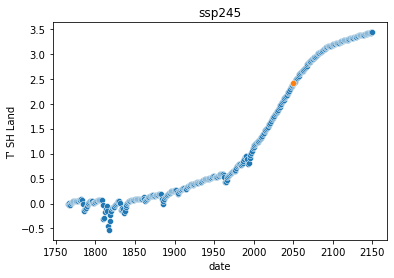

In [6]:
# Demonstrate that the interpolation gives the expected results
ax = sns.scatterplot(x=magicc_df.index, y=magicc_df[pathway])

date = np.datetime64("2050-06-01")
convert_date_to_t_tprime = create_magicc_interpolator(pathway)
sns.scatterplot(x=[date], y=convert_date_to_t_tprime(date))

ax.set_title(pathway)
ax.set_ylabel("T' SH Land")
None # don't return a value

## Load observed data to obtain "average" t_prime used in training

In [7]:
# Load observed dataset
observations_path = Path("/mnt/temp/projects/otago_uni_marsden/data_keep/spg/station_data_hourly") / f"{location}.nc"
observation_ds = xr.open_dataset(observations_path)
observation_ds

<xarray.Dataset>
Dimensions:        (time: 519080)
Coordinates:
  * time           (time) datetime64[ns] 1960-03-31T13:00:00 ... 2019-08-01
Data variables:
    precipitation  (time) float64 ...
    tprime         (time) float64 ...
Attributes:
    git_remote:     https://github.com/bodekerscientific/SPG
    relative_path:  /spg/data_processing/find_stations.py
    creation_date:  2022/02/10, 17:09
    git_sha:        21823b83a6055d32217100d6feb56ba1b21b9860
    author:         Leroy
    email:          leroy@bodekerscientific.com

In [8]:
# Training data was everything but the last 10,000 entries
observation_ds = observation_ds.sel(time=observation_ds["time"][:-10000])
observation_ds

<xarray.Dataset>
Dimensions:        (time: 509080)
Coordinates:
  * time           (time) datetime64[ns] 1960-03-31T13:00:00 ... 2018-06-09T2...
Data variables:
    precipitation  (time) float64 ...
    tprime         (time) float64 ...
Attributes:
    git_remote:     https://github.com/bodekerscientific/SPG
    relative_path:  /spg/data_processing/find_stations.py
    creation_date:  2022/02/10, 17:09
    git_sha:        21823b83a6055d32217100d6feb56ba1b21b9860
    author:         Leroy
    email:          leroy@bodekerscientific.com

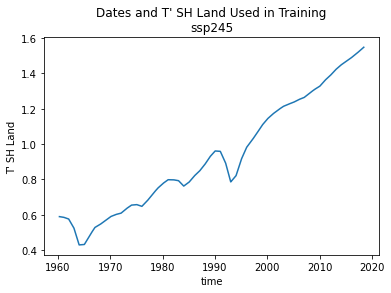

In [9]:
# Get t_prime values for all training dates
t_primes = convert_date_to_t_tprime(observation_ds["time"])
ax = sns.lineplot(
    x=observation_ds["time"],
    y=t_primes
)
ax.set_ylabel("T' SH Land")
ax.set_title(f"Dates and T' SH Land Used in Training\n{pathway}")
None # don't return anything

In [10]:
# "Average" t_prime for the training data
t_prime_training = np.mean(t_primes)
print(f"Average t_prime used in training: {t_prime_training:.2f}K")

Average t_prime used in training: 0.93K


## Load output of stationary SPG

In [11]:
# Load stationary output
location_to_folder = {
    "tauranga": "tauranga_epoch_059",
    "christchurch": "christchurch_epoch_051",
    "dunedin": "dunedin_combined_epoch_082"
}

# Note that the pathway and dates are not important information
base_path = Path("/mnt/temp/projects/otago_uni_marsden/data_keep/spg/ensemble_hourly/v10")
file_path = base_path / location_to_folder[location] / f"{location}_{pathway}_{spg_run:03d}.nc"
print(f"Opening {file_path}")
spg_hourly_ds = xr.open_dataset(file_path)

Opening /mnt/temp/projects/otago_uni_marsden/data_keep/spg/ensemble_hourly/v10/christchurch_epoch_051/christchurch_ssp245_001.nc


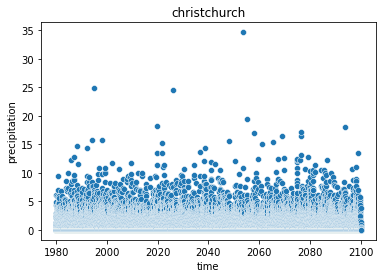

In [12]:
ax = sns.scatterplot(
    x=spg_hourly_ds["time"],
    y=spg_hourly_ds["precipitation"]
)
ax.set_title(location)
None # don't return a value

## Resample hourly data to daily

In [13]:
spg_daily_ds = spg_hourly_ds.resample(time="D").sum()
spg_daily_ds

<xarray.Dataset>
Dimensions:        (time: 43831)
Coordinates:
  * time           (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2100-01-01
Data variables:
    precipitation  (time) float32 0.0 0.0 0.3956 0.0 0.0 ... 0.1598 0.0 9.8 0.0
    tprime         (time) float64 18.63 18.63 18.63 18.63 ... 76.12 76.12 3.18

## Generate delta t_prime compared to training

In [14]:
delta_t_primes = convert_date_to_t_tprime(spg_daily_ds["time"]) - t_prime_training
spg_daily_ds = spg_daily_ds.assign(delta_t_prime=("time",delta_t_primes))

spg_daily_ds

<xarray.Dataset>
Dimensions:        (time: 43831)
Coordinates:
  * time           (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2100-01-01
Data variables:
    precipitation  (time) float32 0.0 0.0 0.3956 0.0 0.0 ... 0.1598 0.0 9.8 0.0
    tprime         (time) float64 18.63 18.63 18.63 18.63 ... 76.12 76.12 3.18
    delta_t_prime  (time) float64 -0.1545 -0.1545 -0.1544 ... 2.25 2.25 2.25

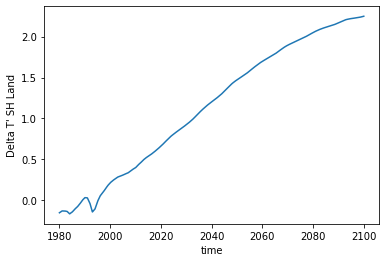

In [15]:
ax = sns.lineplot(
    x=spg_daily_ds["time"],
    y=spg_daily_ds["delta_t_prime"]
)
ax.set_ylabel("Delta T' SH Land")
None # don't return anything

## Convert the precipitation to its quantile

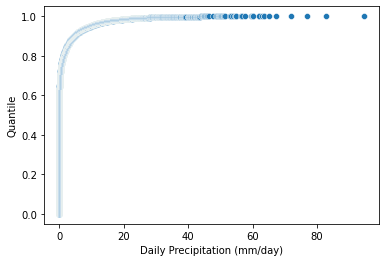

In [16]:
# Obtain the mapping from value to quantile
sorted_precipitation = sorted(spg_daily_ds["precipitation"].to_numpy())
quantiles = np.linspace(0,1, num=len(sorted_precipitation))
ax = sns.scatterplot(
    x=sorted_precipitation,
    y=quantiles
)
ax.set_xlabel("Daily Precipitation (mm/day)")
ax.set_ylabel("Quantile")
from scipy.interpolate import interp1d
precipitation_to_quantile = interp1d(sorted_precipitation, quantiles)

In [17]:
precipitation_to_quantile(0.5)

array(0.74626385)

In [18]:
import warnings
# For zero-valued precipitation a warning is generated; this can be safely ignored
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    quantiles_for_precipitation = precipitation_to_quantile(spg_daily_ds["precipitation"])
quantiles_for_precipitation[np.isnan(quantiles_for_precipitation)] = 0

spg_daily_ds = spg_daily_ds.assign(quantile=("time", quantiles_for_precipitation))
spg_daily_ds

<xarray.Dataset>
Dimensions:        (time: 43831)
Coordinates:
  * time           (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2100-01-01
Data variables:
    precipitation  (time) float32 0.0 0.0 0.3956 0.0 0.0 ... 0.1598 0.0 9.8 0.0
    tprime         (time) float64 18.63 18.63 18.63 18.63 ... 76.12 76.12 3.18
    delta_t_prime  (time) float64 -0.1545 -0.1545 -0.1544 ... 2.25 2.25 2.25
    quantile       (time) float64 0.0 0.0 0.7327 0.0 ... 0.6876 0.0 0.9504 0.0

<AxesSubplot:ylabel='Count'>

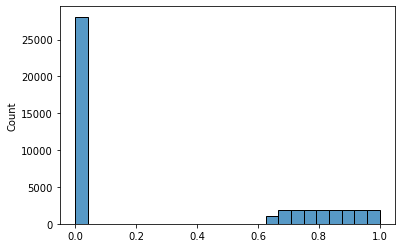

In [19]:
sns.histplot(spg_daily_ds["quantile"])

## Load Weather@Home datasets

In [20]:
t_prime_sh_land = {
    "batch_870_ant": 1.728,
    "batch_871_ant": 2.277,
    "batch_872_ant": 3.384
}

In [21]:
def load_weather_at_home(data_path):
    files = sorted(data_path.glob("*.nc"))
    precipitations = []
    incomplete_datasets_count = 0
    for file in files:
        dataset = xr.open_dataset(file)
        if len(dataset['time1']) != 600:
            incomplete_datasets_count += 1
            continue
        # Extract the last year of data and get rid of the 'z0' axis
        dataset = dataset.isel(time1=slice(600-360, 600), z0=0)
        precipitation = dataset["precipitation"].values
        precipitations.append(precipitation)

    precipitations = np.concatenate(precipitations)
    
    # Convert units to mm/day
    precipitations = precipitations * 24*60*60

    processed_count = len(files) - incomplete_datasets_count
    print(f"Processed {processed_count:,} complete files (skipped {incomplete_datasets_count} incomplete datasets).")
    return precipitations

In [22]:
# Load all data
base_data_path = Path(f"/mnt/temp/projects/otago_uni_marsden/data_keep/weather_at_home/{location}/")
weather_at_home = {}
for sim_label in t_prime_sh_land.keys():
    print(f"Loading {sim_label}...")
    data_path = base_data_path / sim_label
    precipitation = load_weather_at_home(data_path)
    weather_at_home[sim_label] = precipitation
print("Finished loading")

Loading batch_870_ant...
Processed 2,543 complete files (skipped 113 incomplete datasets).
Loading batch_871_ant...
Processed 2,496 complete files (skipped 147 incomplete datasets).
Loading batch_872_ant...
Processed 2,549 complete files (skipped 131 incomplete datasets).
Finished loading


## Analyse Weather@Home

In [23]:
def generate_dataframe(quantile):
    sim_labels = weather_at_home.keys()
    temperatures = [t_prime_sh_land[key] for key in sim_labels]
    results_at_quantile = [np.quantile(weather_at_home[key], quantile) for key in sim_labels]

    df = pd.DataFrame({
        "temperature": temperatures,
        "precipitation": results_at_quantile
    })
    df = df.set_index("temperature")
    return df

In [24]:
def analyse_dataframe(df):
    def func(x, p_zero, rate):
        return p_zero * np.exp(rate*x)

    params, _ = curve_fit(
        func, 
        df.index.to_numpy(), 
        df["precipitation"].to_numpy(),
        p0=[0,0]
    )

    assert params[0] >= 0, "p_zero is negative"

    return {
        "f": func,
        "params": params
    }

In [25]:
def plot_one(df, fit, title):
    ax = sns.scatterplot(
        x=df.index,
        y=df["precipitation"],
    )
    xs = np.linspace(
        np.min(df.index),
        np.max(df.index),
        num=100
    )
    func = fit["f"]
    params = fit["params"]
    ys = func(xs, *params)
    sns.lineplot(
        x=xs,
        y=ys,
        hue=0,
        legend=False,
    )
    ax.set_ylabel("Precipitation (mm/day)")
    ax.set_xlabel("T' SH Land (deg C)")
    ax.set_title(title+f"\np_zero: {params[0]:.2f} mm/day, rate: {params[1]*100:.1f}%")

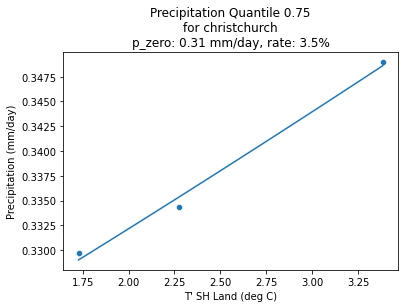

In [26]:
quantile = 0.75
df = generate_dataframe(quantile)
fit = analyse_dataframe(df)
title = f"Precipitation Quantile {quantile}\nfor {location}"
plot_one(df, fit, title)

In [27]:
def analyse_and_plot_many(quantiles):
    # Loop through quantiles, produce combined dataframe
    p_zeros = []
    rates = []
    qs = []
    for q in quantiles:
        df = generate_dataframe(q)
        try:
            fit = analyse_dataframe(df)
        except:
            print(f"p_zero was negative for quantile {q}")
            continue
        params = fit["params"]
        qs.append(q)
        p_zeros.append(params[0])
        rates.append(params[1])
    result = pd.DataFrame({
        "quantile": qs,
        "p_zero": p_zeros,
        "rate": rates
    })
    return result

In [28]:
quantiles = np.linspace(0,1, num=1001)
df = analyse_and_plot_many(quantiles)
df

p_zero was negative for quantile 0.0
p_zero was negative for quantile 0.001
p_zero was negative for quantile 0.002
p_zero was negative for quantile 0.003
p_zero was negative for quantile 0.004
p_zero was negative for quantile 0.005
p_zero was negative for quantile 0.006
p_zero was negative for quantile 0.007


/home/matthew/miniconda3/envs/spg/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


,quantile,p_zero,rate
0,0.008,0.000000,0.000000
1,0.009,0.000000,0.000000
2,0.010,0.000000,0.000000
3,0.011,0.000000,0.000000
4,0.012,0.000000,0.000000
...,...,...,...
988,0.996,23.797241,0.054325
989,0.997,27.364209,0.053702
990,0.998,32.591881,0.056607
991,0.999,41.636752,0.062481


In [29]:
# Function to interpolate rate given quantile
interpolate_rate = interp1d(
    x=df["quantile"].to_numpy(), 
    y=df["rate"].to_numpy(),
    fill_value="extrapolate"
)

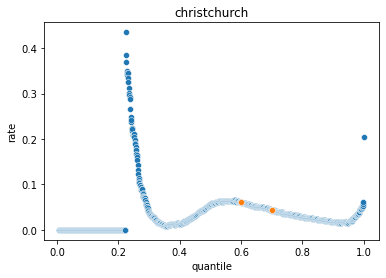

In [30]:
ax = sns.scatterplot(
    x=df["quantile"],
    y=df["rate"]
)
ax.set_title(location)

qs=[0.6,0.7]
sns.scatterplot(
    x=qs,
    y=interpolate_rate(qs)
)
None # don't return a value

## Find rate, given quantile

In [31]:
quantiles = spg_daily_ds["quantile"].to_numpy()
rates = interpolate_rate(quantiles)
spg_daily_ds = spg_daily_ds.assign(rate=("time",rates))
spg_daily_ds

<xarray.Dataset>
Dimensions:        (time: 43831)
Coordinates:
  * time           (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2100-01-01
Data variables:
    precipitation  (time) float32 0.0 0.0 0.3956 0.0 0.0 ... 0.1598 0.0 9.8 0.0
    tprime         (time) float64 18.63 18.63 18.63 18.63 ... 76.12 76.12 3.18
    delta_t_prime  (time) float64 -0.1545 -0.1545 -0.1544 ... 2.25 2.25 2.25
    quantile       (time) float64 0.0 0.0 0.7327 0.0 ... 0.6876 0.0 0.9504 0.0
    rate           (time) float64 0.0 0.0 0.03897 0.0 ... 0.0468 0.0 0.01638 0.0

<AxesSubplot:xlabel='quantile', ylabel='rate'>

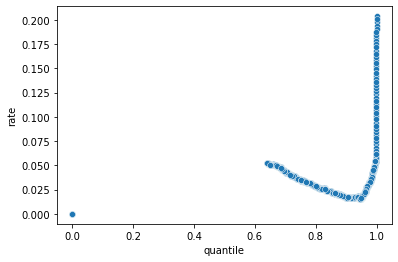

In [32]:
sns.scatterplot(
    x=spg_daily_ds["quantile"],
    y=spg_daily_ds["rate"]
)

## Calculate multiplier, given rate and delta T'

In [33]:
multipliers = np.exp(spg_daily_ds["delta_t_prime"].to_numpy() * spg_daily_ds["rate"].to_numpy())
spg_daily_ds = spg_daily_ds.assign(multiplier=("time", multipliers))
spg_daily_ds

<xarray.Dataset>
Dimensions:        (time: 43831)
Coordinates:
  * time           (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2100-01-01
Data variables:
    precipitation  (time) float32 0.0 0.0 0.3956 0.0 0.0 ... 0.1598 0.0 9.8 0.0
    tprime         (time) float64 18.63 18.63 18.63 18.63 ... 76.12 76.12 3.18
    delta_t_prime  (time) float64 -0.1545 -0.1545 -0.1544 ... 2.25 2.25 2.25
    quantile       (time) float64 0.0 0.0 0.7327 0.0 ... 0.6876 0.0 0.9504 0.0
    rate           (time) float64 0.0 0.0 0.03897 0.0 ... 0.0468 0.0 0.01638 0.0
    multiplier     (time) float64 1.0 1.0 0.994 1.0 1.0 ... 1.111 1.0 1.038 1.0

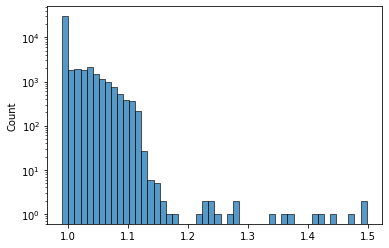

In [34]:
ax = sns.histplot(
    spg_daily_ds["multiplier"],
    bins=50
)
ax.set_yscale("log")

In [35]:
non_stationary_precipitation = spg_daily_ds["precipitation"].to_numpy() * spg_daily_ds["multiplier"].to_numpy()
spg_daily_ds = spg_daily_ds.assign(non_stationary_precipitation=("time",non_stationary_precipitation))
spg_daily_ds

<xarray.Dataset>
Dimensions:                       (time: 43831)
Coordinates:
  * time                          (time) datetime64[ns] 1980-01-01 ... 2100-0...
Data variables:
    precipitation                 (time) float32 0.0 0.0 0.3956 ... 0.0 9.8 0.0
    tprime                        (time) float64 18.63 18.63 ... 76.12 3.18
    delta_t_prime                 (time) float64 -0.1545 -0.1545 ... 2.25 2.25
    quantile                      (time) float64 0.0 0.0 0.7327 ... 0.9504 0.0
    rate                          (time) float64 0.0 0.0 0.03897 ... 0.01638 0.0
    multiplier                    (time) float64 1.0 1.0 0.994 ... 1.0 1.038 1.0
    non_stationary_precipitation  (time) float64 0.0 0.0 0.3933 ... 10.17 0.0

In [36]:
x=sorted(spg_daily_ds["precipitation"].to_numpy())
y=sorted(spg_daily_ds["non_stationary_precipitation"].to_numpy())

Text(0, 0.5, 'Non-Stationary')

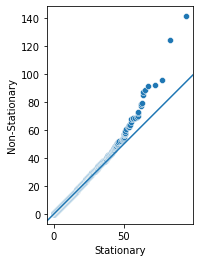

In [37]:
ax = sns.scatterplot(x=x,y=y)
ax.axline((0,0), slope=1)
ax.set_aspect("equal")
ax.set_xlabel("Stationary")
ax.set_ylabel("Non-Stationary")

In [38]:
spg_daily_ds.to_netcdf(f"non_stationary_daily_{location}_{pathway}_{spg_run:03d}.nc")

## Convert hourly data using daily multipliers

In [39]:
spg_hourly_ds

<xarray.Dataset>
Dimensions:        (time: 1051921)
Coordinates:
  * time           (time) datetime64[ns] 1980-01-01 ... 2100-01-01
Data variables:
    precipitation  (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.05683 0.0 0.0 0.0
    tprime         (time) float64 ...
Attributes:
    git_remote:     https://github.com/bodekerscientific/SPG
    relative_path:  spg/run.py
    creation_date:  2022/03/18, 10:53
    git_sha:        48cf5b8766ef1574e05cf56e1e4de660df17170b
    author:         Leroy
    email:          leroy@bodekerscientific.com

In [49]:
# Get date from timestamps
timestamps = spg_hourly_ds["time"]
timestamps = timestamps.to_numpy()
dates = timestamps.astype('datetime64[D]')

In [51]:
# Get multipliers for the given dates
multipliers = spg_daily_ds["multiplier"].sel(time=dates).to_numpy()
spg_hourly_ds = spg_hourly_ds.assign(multipler=("time", multipliers))
spg_hourly_ds

<xarray.Dataset>
Dimensions:        (time: 1051921)
Coordinates:
  * time           (time) datetime64[ns] 1980-01-01 ... 2100-01-01
Data variables:
    precipitation  (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.05683 0.0 0.0 0.0
    tprime         (time) float64 ...
    multipler      (time) float64 1.0 1.0 1.0 1.0 1.0 ... 1.038 1.038 1.038 1.0
Attributes:
    git_remote:     https://github.com/bodekerscientific/SPG
    relative_path:  spg/run.py
    creation_date:  2022/03/18, 10:53
    git_sha:        48cf5b8766ef1574e05cf56e1e4de660df17170b
    author:         Leroy
    email:          leroy@bodekerscientific.com

In [54]:
# Apply multipliers to generate non-stationary precipitation
non_stationary_precipitation = spg_hourly_ds["precipitation"].to_numpy() * multipliers
spg_hourly_ds = spg_hourly_ds.assign(non_stationary_precipitation=("time", non_stationary_precipitation))
spg_hourly_ds

<xarray.Dataset>
Dimensions:                       (time: 1051921)
Coordinates:
  * time                          (time) datetime64[ns] 1980-01-01 ... 2100-0...
Data variables:
    precipitation                 (time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    tprime                        (time) float64 ...
    multipler                     (time) float64 1.0 1.0 1.0 ... 1.038 1.038 1.0
    non_stationary_precipitation  (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    git_remote:     https://github.com/bodekerscientific/SPG
    relative_path:  spg/run.py
    creation_date:  2022/03/18, 10:53
    git_sha:        48cf5b8766ef1574e05cf56e1e4de660df17170b
    author:         Leroy
    email:          leroy@bodekerscientific.com

In [57]:
# Remove t_prime from hourly dataset because we didn't use that one
spg_hourly_ds = spg_hourly_ds.drop("tprime")

In [58]:
x=sorted(spg_hourly_ds["precipitation"].to_numpy())
y=sorted(spg_hourly_ds["non_stationary_precipitation"].to_numpy())

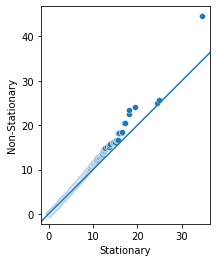

In [60]:
ax = sns.scatterplot(x=x,y=y)
ax.axline((0,0), slope=1)
ax.set_aspect("equal")
ax.set_xlabel("Stationary")
ax.set_ylabel("Non-Stationary")
None # don't return a value

In [61]:
spg_hourly_ds.to_netcdf(f"non_stationary_hourly_{location}_{pathway}_{spg_run:03d}.nc")